# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [2]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

# Challenge 0 - Import a MySQL table into python:

In this lab, we will twist things up a little. Do you remember your good old friend SQL?
Well, it's time to bring him back and use it in our lab pipeline.

1º- Open the wholesale_customers_data.sql file in MySQL Workbench and run the script into a desired schema.

2º- Create a connection using sqlalchemy from python to mysql and load the table into a variable called *customers*

In [3]:
#Create a connection with create_engine to MySQL Workbench:

import pymysql
connection = pymysql.connect(host='localhost',
                             port=3306,
                             user='root',
                             password='Delicias00!',
                             db='sys')

cursor = connection.cursor()
sql = 'select * from wholesale_customers_data'
cursor.execute(sql)
result = cursor.fetchall()
weather_df = pd.DataFrame(result)

sql_col = 'show columns from wholesale_customers_data'
cursor.execute(sql_col)
result_col = cursor.fetchall()

weather_df.columns = list(pd.DataFrame(result_col)[0])

# Challenge 1 - Describe the Dataset

Your already loaded dataset contains information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

In case of curiosity, the origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


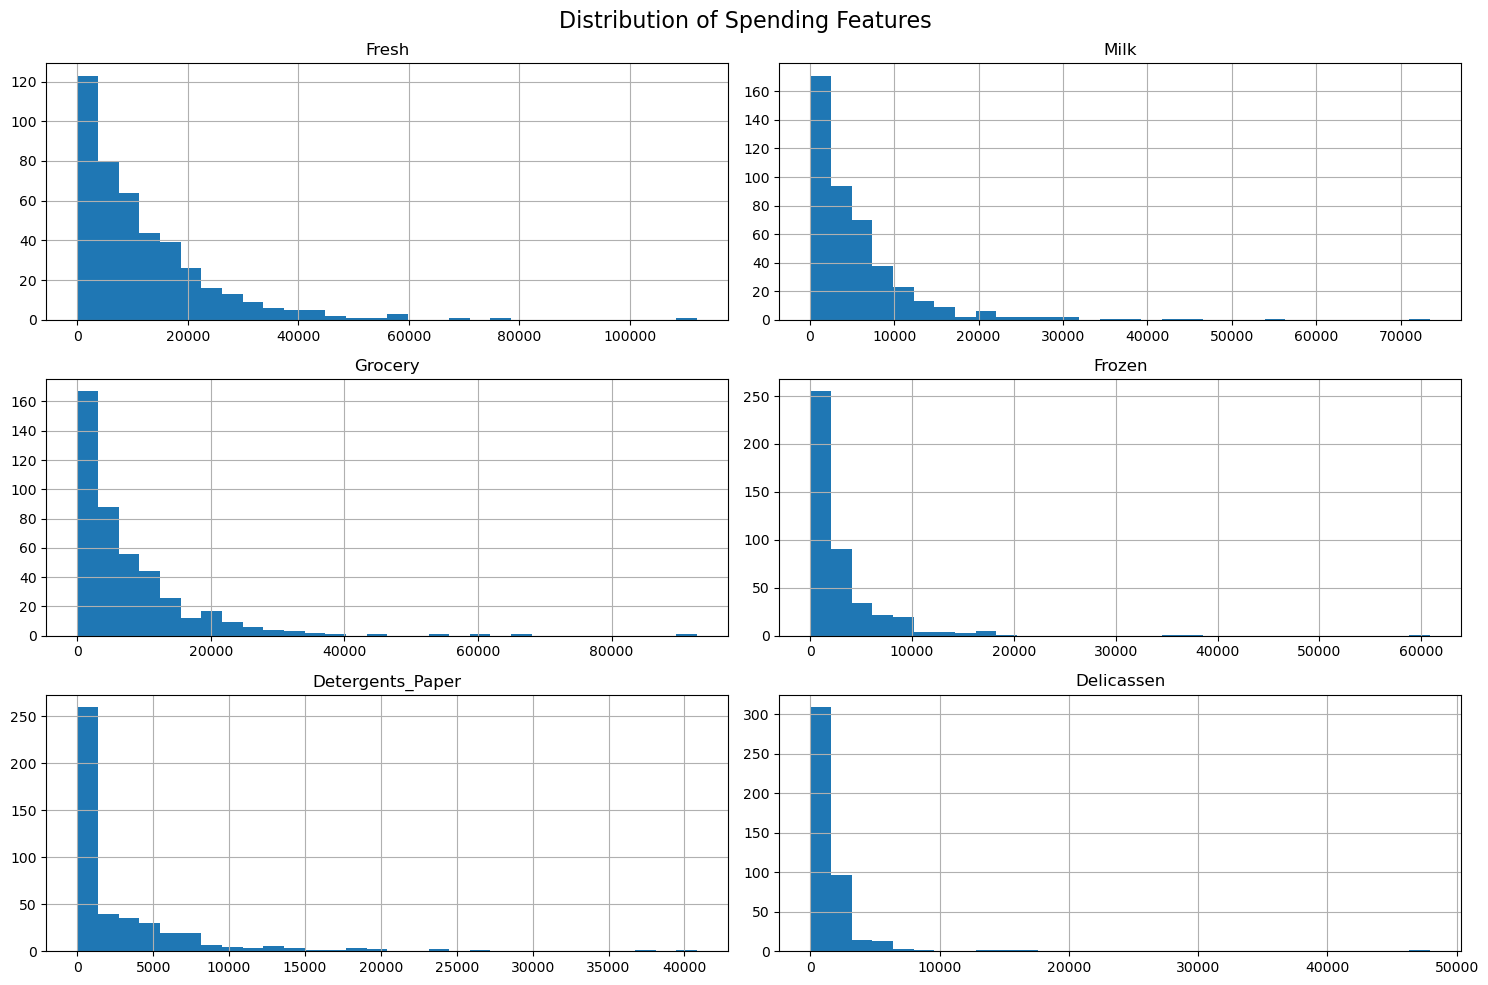

In [4]:
# Your code here:

# Summary statistics and exploration
weather_df.describe()
weather_df.info()
weather_df.isnull().sum()
weather_df.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Plot distributions for each spending category
weather_df.drop(columns=['Channel', 'Region']).hist(figsize=(15, 10), bins=30)
plt.suptitle("Distribution of Spending Features", fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
# Your observations here:

# 1. All columns are numeric – no categorical values to convert.
# 2. There are no missing values.
# 3. The dataset is right-skewed, especially for Fresh, Frozen, and Delicassen – indicating a few customers spend much more than the rest.
# 4. Strong correlation between Grocery and Detergents_Paper (likely due to retail bulk purchases).
# 5. The Pareto principle seems evident – a small number of customers account for most of the spending.
# 6. We may consider log-transforming skewed features or using robust scalers for modeling.

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [8]:
# Your code here
# Optional log-transform for skewed features (helps with clustering and outliers)
import numpy as np

columns_to_log = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
customers_log = weather_df.copy()
customers_log[columns_to_log] = customers_log[columns_to_log].apply(lambda x: np.log1p(x))  # log(1+x) avoids log(0)


In [9]:
# Your comment here
# Most features are heavily right-skewed (especially Fresh, Frozen, Delicassen).
# Applying log transformation reduces the impact of extreme outliers and makes the distribution more normal.
# This is a common preprocessing step before clustering algorithms like K-Means.

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [11]:
# Your import here:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
customers_scale = scaler.fit_transform(customers_log.drop(columns=['Region', 'Channel']))


# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [13]:
# Your code here:
from sklearn.cluster import KMeans

# Inicializamos KMeans con 3 clusters (puedes ajustar este valor)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(customers_scale)

# Guardamos etiquetas
customers_log['labels'] = kmeans.labels_
customers_log

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
0,2,3,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678,2
1,2,3,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682,2
2,2,3,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632,2
3,1,3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412,1
4,2,3,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718,2
...,...,...,...,...,...,...,...,...,...
435,1,3,10.299037,9.396986,9.682092,9.483112,5.209486,7.698483,2
436,1,3,10.577172,7.266827,6.639876,8.414274,4.543295,7.760893,1
437,2,3,9.584108,9.647885,10.317053,6.082219,9.605216,7.532624,2
438,1,3,9.239025,7.591862,7.711101,6.946014,5.129899,7.661998,1


Count the values in `labels`.

In [14]:
# Your code here:
customers_log['labels'].value_counts()


labels
1    216
2    143
0     81
Name: count, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [16]:
# Your code here
from sklearn.cluster import DBSCAN

# Aplicamos DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(customers_scale)

# Guardamos etiquetas
customers_log['labels_DBSCAN'] = dbscan.labels_
customers_log

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN
0,2,3,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678,2,-1
1,2,3,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682,2,0
2,2,3,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632,2,-1
3,1,3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412,1,-1
4,2,3,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718,2,-1
...,...,...,...,...,...,...,...,...,...,...
435,1,3,10.299037,9.396986,9.682092,9.483112,5.209486,7.698483,2,-1
436,1,3,10.577172,7.266827,6.639876,8.414274,4.543295,7.760893,1,-1
437,2,3,9.584108,9.647885,10.317053,6.082219,9.605216,7.532624,2,-1
438,1,3,9.239025,7.591862,7.711101,6.946014,5.129899,7.661998,1,-1


Count the values in `labels_DBSCAN`.

In [17]:
# Your code here
customers_log['labels_DBSCAN'].value_counts()


labels_DBSCAN
-1    435
 0      5
Name: count, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

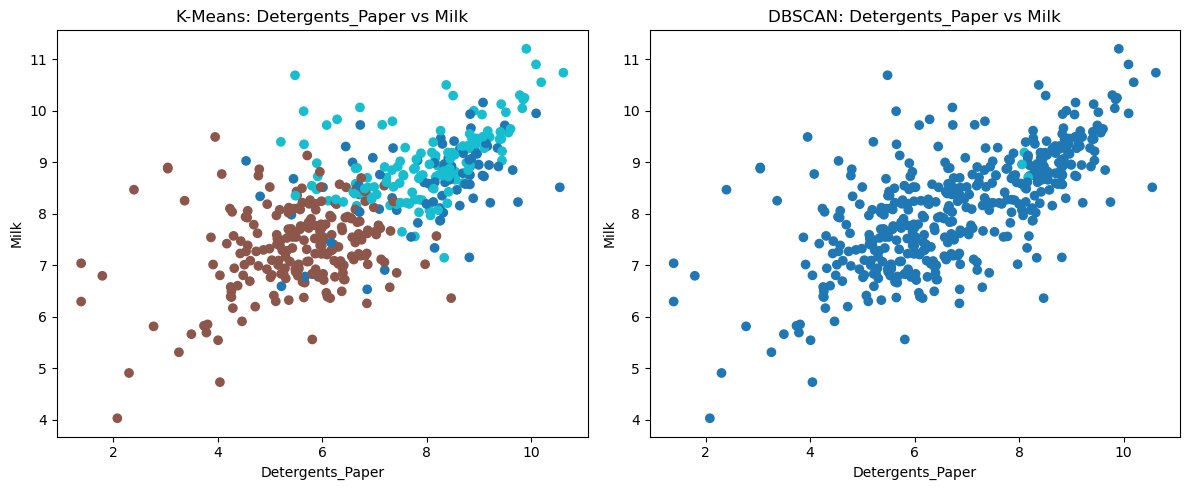

In [18]:
# Your code here:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# KMeans
plt.subplot(1, 2, 1)
plt.scatter(customers_log['Detergents_Paper'], customers_log['Milk'], c=customers_log['labels'], cmap='tab10')
plt.title("K-Means: Detergents_Paper vs Milk")
plt.xlabel("Detergents_Paper")
plt.ylabel("Milk")

# DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(customers_log['Detergents_Paper'], customers_log['Milk'], c=customers_log['labels_DBSCAN'], cmap='tab10')
plt.title("DBSCAN: Detergents_Paper vs Milk")
plt.xlabel("Detergents_Paper")
plt.ylabel("Milk")

plt.tight_layout()
plt.show()


Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

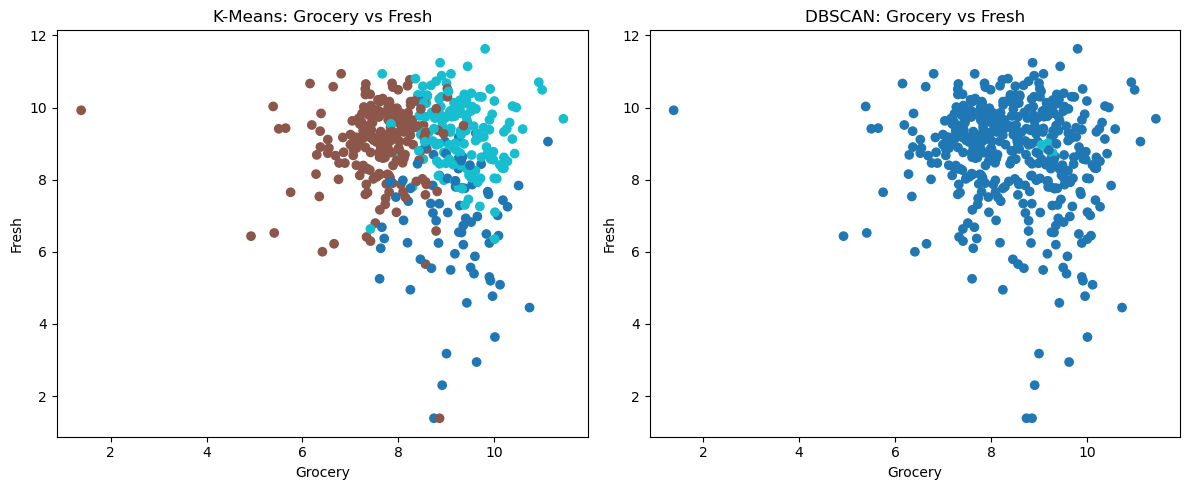

In [19]:
# Your code here:
plt.figure(figsize=(12, 5))

# KMeans
plt.subplot(1, 2, 1)
plt.scatter(customers_log['Grocery'], customers_log['Fresh'], c=customers_log['labels'], cmap='tab10')
plt.title("K-Means: Grocery vs Fresh")
plt.xlabel("Grocery")
plt.ylabel("Fresh")

# DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(customers_log['Grocery'], customers_log['Fresh'], c=customers_log['labels_DBSCAN'], cmap='tab10')
plt.title("DBSCAN: Grocery vs Fresh")
plt.xlabel("Grocery")
plt.ylabel("Fresh")

plt.tight_layout()
plt.show()


Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

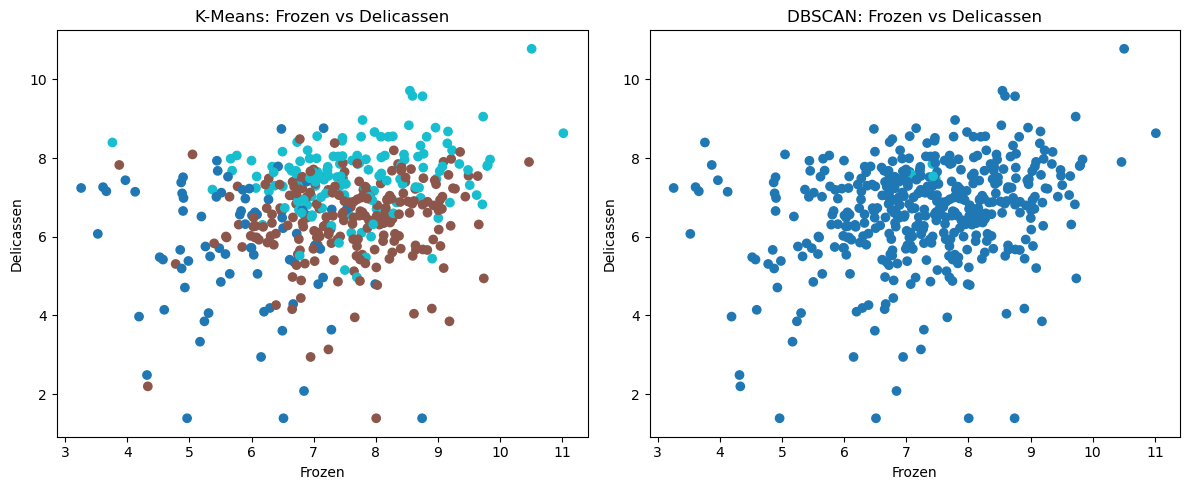

In [20]:
# Your code here:
plt.figure(figsize=(12, 5))

# KMeans
plt.subplot(1, 2, 1)
plt.scatter(customers_log['Frozen'], customers_log['Delicassen'], c=customers_log['labels'], cmap='tab10')
plt.title("K-Means: Frozen vs Delicassen")
plt.xlabel("Frozen")
plt.ylabel("Delicassen")

# DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(customers_log['Frozen'], customers_log['Delicassen'], c=customers_log['labels_DBSCAN'], cmap='tab10')
plt.title("DBSCAN: Frozen vs Delicassen")
plt.xlabel("Frozen")
plt.ylabel("Delicassen")

plt.tight_layout()
plt.show()


Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [21]:
# Your code here:
# Agrupar por clusters K-Means
means_kmeans = customers_log.groupby('labels').mean()

# Agrupar por clusters DBSCAN
means_dbscan = customers_log.groupby('labels_DBSCAN').mean()

means_kmeans, means_dbscan


(         Channel    Region     Fresh      Milk   Grocery    Frozen  \
 labels                                                               
 0       1.580247  2.530864  6.959284  8.599717  9.154707  5.829096   
 1       1.013889  2.500000  9.023489  7.356229  7.611490  7.591402   
 2       1.643357  2.615385  9.298337  9.006910  9.293407  7.702633   
 
         Detergents_Paper  Delicassen  labels_DBSCAN  
 labels                                               
 0               8.046416    5.778821      -1.000000  
 1               5.516560    6.430851      -1.000000  
 2               8.007323    7.539393      -0.965035  ,
                 Channel    Region     Fresh      Milk   Grocery    Frozen  \
 labels_DBSCAN                                                               
 -1             1.317241  2.542529  8.730878  8.113539  8.433839  7.303014   
  0             1.800000  2.600000  8.901228  8.824239  9.170050  7.312993   
 
                Detergents_Paper  Delicassen    label

Which algorithm appears to perform better?

In [ ]:
# Your observations here
# K-Means tiende a crear clusters más balanceados y es fácil de interpretar, pero requiere especificar k.
# DBSCAN detecta mejor outliers (etiqueta -1) y encuentra clusters de forma libre, pero a veces agrupa demasiado poco.
# En este caso, K-Means parece formar grupos más útiles para segmentación de clientes.

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

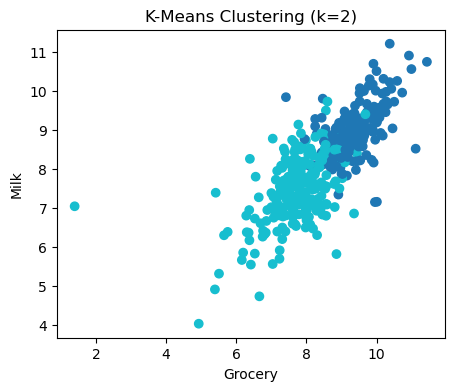

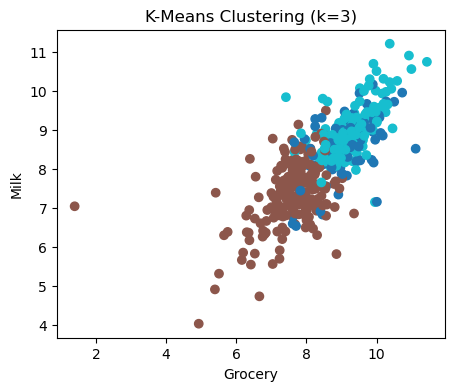

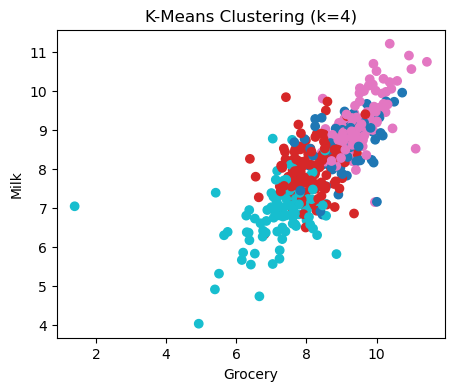

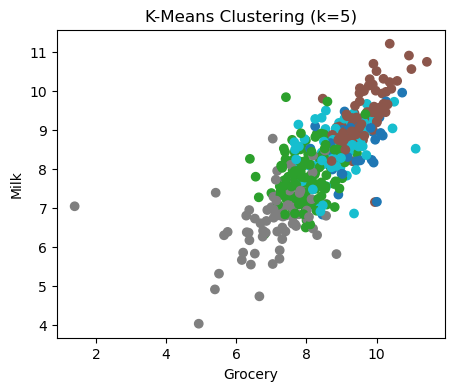

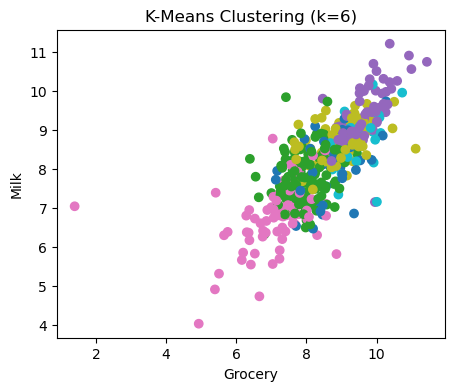

In [22]:
# Your code here
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Probar con 2 a 6 clusters
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(customers_scale)

    plt.figure(figsize=(5, 4))
    plt.scatter(customers_log['Grocery'], customers_log['Milk'], c=labels, cmap='tab10')
    plt.title(f"K-Means Clustering (k={k})")
    plt.xlabel("Grocery")
    plt.ylabel("Milk")
    plt.show()


In [23]:
# Your comment here
# Based on the scatter plots, k=3 or k=4 gives the clearest separation between groups.
# With k=2, clusters are too broad. With k=5 or 6, the separation becomes noisy.
# Visually, k=3 appears to offer a balanced and interpretable segmentation of customers.


# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

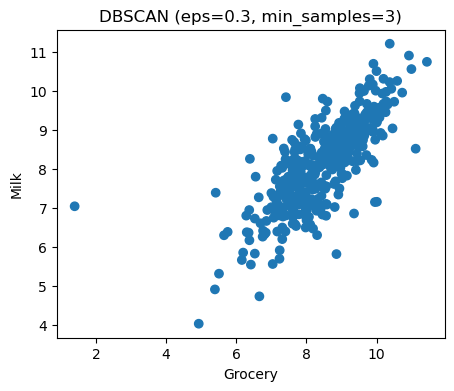

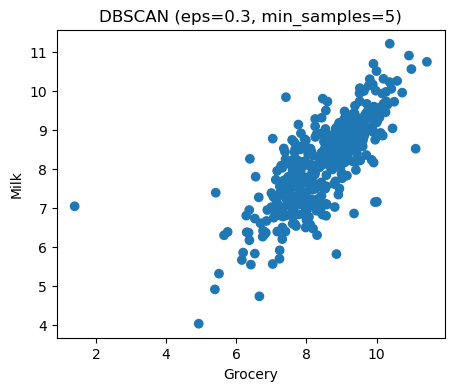

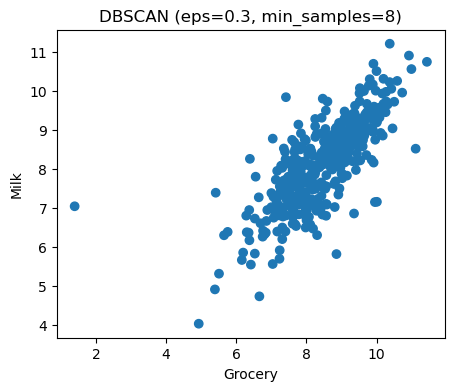

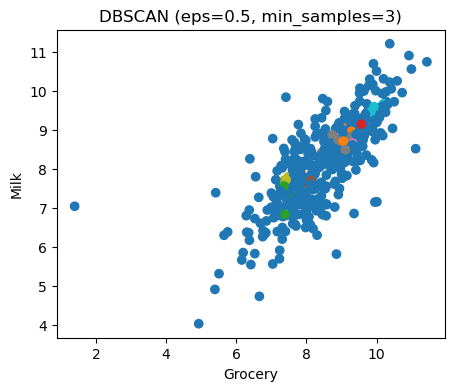

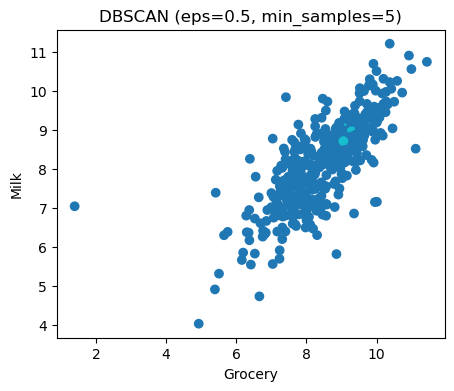

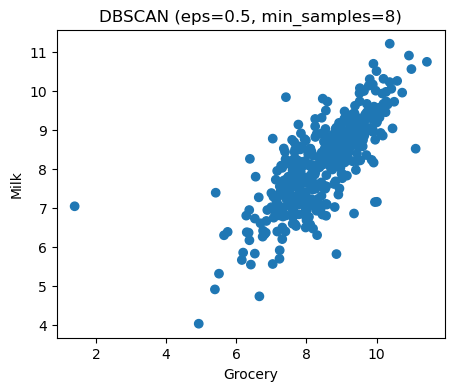

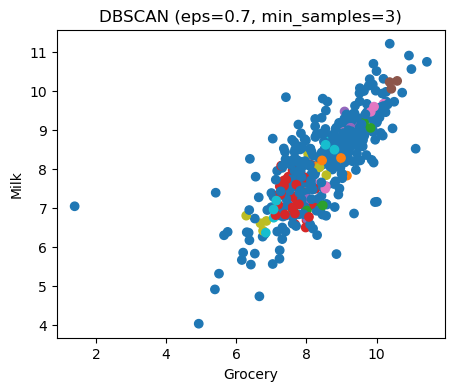

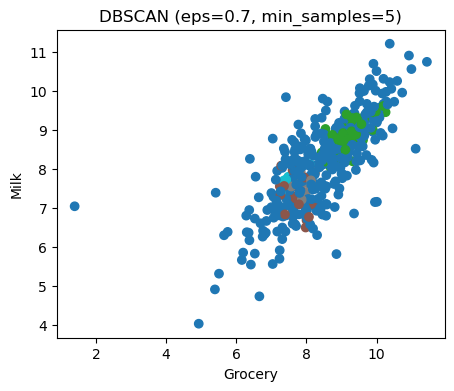

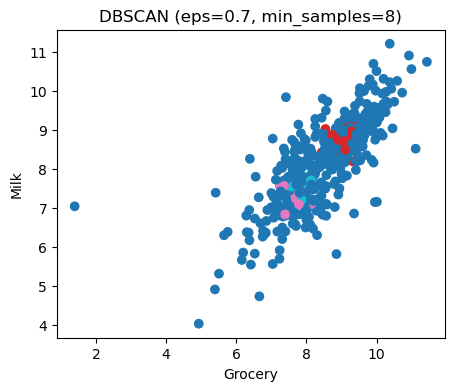

In [24]:
# Your code here
from sklearn.cluster import DBSCAN

# Probar distintas combinaciones de eps y min_samples
for eps in [0.3, 0.5, 0.7]:
    for min_samples in [3, 5, 8]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(customers_scale)

        plt.figure(figsize=(5, 4))
        plt.scatter(customers_log['Grocery'], customers_log['Milk'], c=labels, cmap='tab10')
        plt.title(f"DBSCAN (eps={eps}, min_samples={min_samples})")
        plt.xlabel("Grocery")
        plt.ylabel("Milk")
        plt.show()


In [ ]:
# Your comment here
# Lower eps (0.3) creates too many small noisy clusters.
# eps=0.5 with min_samples=5 offers a decent balance with few noise points and two clear clusters.
# eps=0.7 results in larger clusters but sometimes merges distinct groups.
# Overall, eps=0.5 and min_samples=5 looks like a good configuration.
